# Forest Fire Prediction Project - Model Training & Hyperparameter Tuning

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook implements and evaluates supervised learning models:
1. K-Nearest Neighbors (KNN)
2. Decision Tree
3. Random Forest

Each model includes:
- Baseline evaluation
- Hyperparameter tuning with GridSearchCV
- Performance visualization
- Comparative analysis


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Visualization
from sklearn.tree import plot_tree

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)



## 1. Load and Prepare Data

In [2]:
def load_and_prepare_data(filepath):
    """
    Load cleaned dataset and prepare for modeling.
    
    Parameters:
    -----------
    filepath : str
        Path to cleaned dataset
    
    Returns:
    --------
    X, y : arrays
        Features and target
    df : DataFrame
        Original dataframe
    """
    
    print("="*70)
    print("LOADING AND PREPARING DATA")
    print("="*70)
    
    df = pd.read_csv(filepath)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nFeatures: {df.shape[1] - 1}")
    print(f"Samples: {df.shape[0]:,}")
    
    # Separate features and target
    X = df.drop(columns=["fire"]).values
    y = df["fire"].values
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    
    # Target distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n Target Distribution:")
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls}: {cnt:,} ({cnt/len(y)*100:.1f}%)")
    
    print("="*70)
    
    return X, y, df

# Load data
X, y, df = load_and_prepare_data("../data/processed/Fire/final.csv")


LOADING AND PREPARING DATA
Dataset shape: (104372, 18)

Features: 17
Samples: 104,372

Feature matrix shape: (104372, 17)
Target vector shape: (104372,)

 Target Distribution:
  Class 0: 90,156 (86.4%)
  Class 1: 14,216 (13.6%)


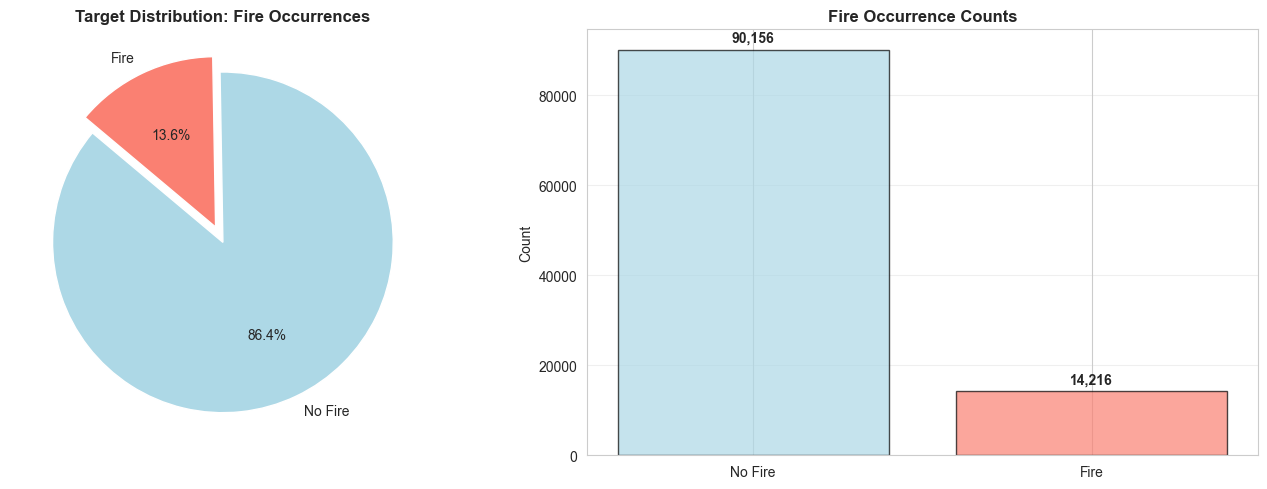

Total fire occurrences: 14,216
Total non-fire samples: 90,156
Imbalance ratio: 1:6.34


In [3]:

## 1.1 Visualize Target Distribution
def visualize_target_distribution(y):
    """Visualize target variable distribution."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart
    unique, counts = np.unique(y, return_counts=True)
    colors = ['lightblue', 'salmon']
    axes[0].pie(counts, labels=['No Fire', 'Fire'], autopct='%1.1f%%', 
               startangle=140, colors=colors, explode=(0, 0.1))
    axes[0].set_title('Target Distribution: Fire Occurrences', 
                     fontsize=12, fontweight='bold')
    
    # Bar chart
    axes[1].bar(['No Fire', 'Fire'], counts, color=colors, edgecolor='black', alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('Fire Occurrence Counts', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, (cls, cnt) in enumerate(zip(['No Fire', 'Fire'], counts)):
        axes[1].text(i, cnt + max(counts)*0.02, f'{cnt:,}', 
                    ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total fire occurrences: {counts[1]:,}")
    print(f"Total non-fire samples: {counts[0]:,}")
    print(f"Imbalance ratio: 1:{counts[0]/counts[1]:.2f}")

visualize_target_distribution(y)


## 2. Train-Test Split

TRAIN-TEST SPLIT
Test size: 20%
Random state: 42

Training set: 83,497 samples
Test set: 20,875 samples


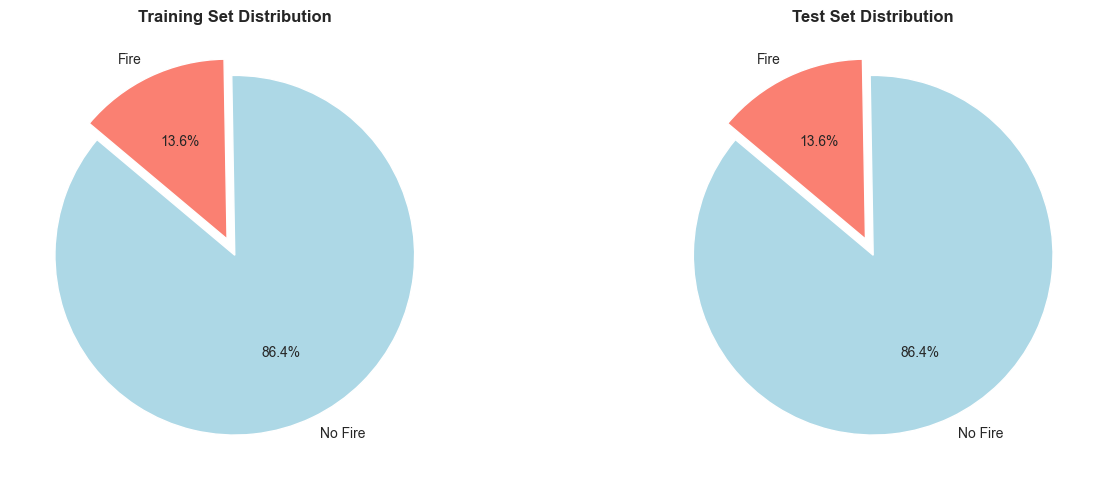

In [4]:

def create_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Create stratified train-test split.
    
    Parameters:
    -----------
    X : array
        Feature matrix
    y : array
        Target vector
    test_size : float
        Proportion of test set
    random_state : int
        Random seed
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Train and test splits
    """
    
    print("="*70)
    print("TRAIN-TEST SPLIT")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Test size: {test_size*100:.0f}%")
    print(f"Random state: {random_state}")
    print(f"\nTraining set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    
    # Visualize split distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Training set
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    axes[0].pie(counts_train, labels=['No Fire', 'Fire'], autopct='%1.1f%%',
               startangle=140, colors=['lightblue', 'salmon'], explode=(0, 0.1))
    axes[0].set_title('Training Set Distribution', fontsize=12, fontweight='bold')
    
    # Test set
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    axes[1].pie(counts_test, labels=['No Fire', 'Fire'], autopct='%1.1f%%',
               startangle=140, colors=['lightblue', 'salmon'], explode=(0, 0.1))
    axes[1].set_title('Test Set Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    
    return X_train, X_test, y_train, y_test

# Create split
X_train, X_test, y_train, y_test = create_train_test_split(X, y)


## 3. Handle Class Imbalance with SMOTE-Tomek

CLASS BALANCING: SMOTE-TOMEK
Before SMOTE-Tomek:
  Class 0: 72,124
  Class 1: 11,373

After SMOTE-Tomek:
  Class 0: 71,701
  Class 1: 71,701


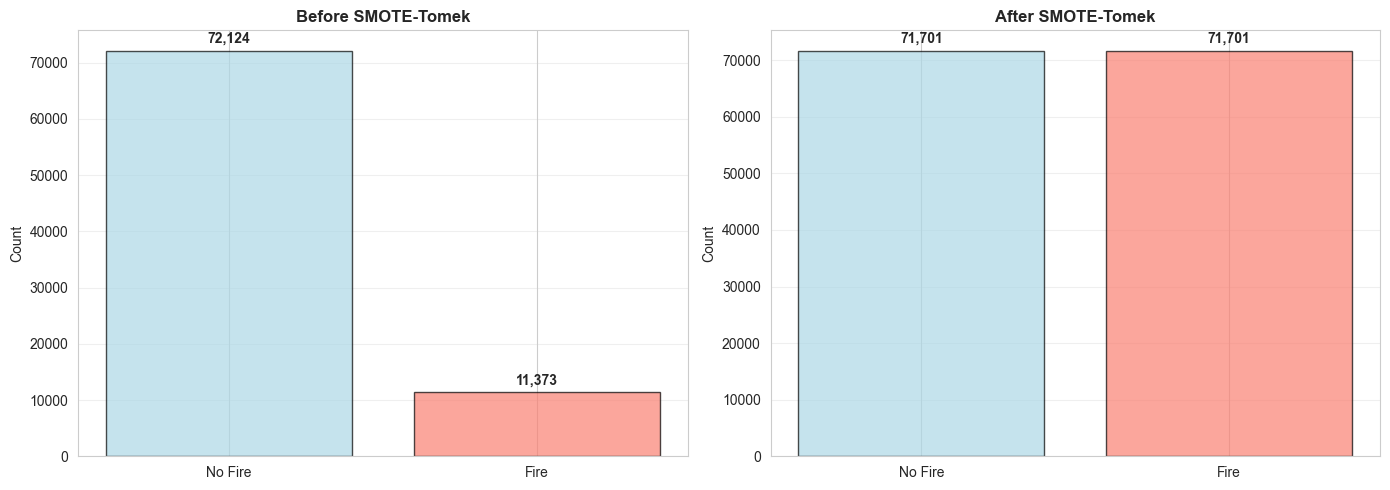


 Training samples: 83,497 → 143,402


In [5]:

def apply_smote_tomek(X_train, y_train):
    """
    Apply SMOTE-Tomek to balance classes.
    
    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    
    Returns:
    --------
    X_resampled, y_resampled : arrays
        Balanced training data
    """
    
    print("="*70)
    print("CLASS BALANCING: SMOTE-TOMEK")
    print("="*70)
    
    # Before
    unique_before, counts_before = np.unique(y_train, return_counts=True)
    print("Before SMOTE-Tomek:")
    for cls, cnt in zip(unique_before, counts_before):
        print(f"  Class {cls}: {cnt:,}")
    
    # Apply SMOTE-Tomek
    smote = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # After
    unique_after, counts_after = np.unique(y_resampled, return_counts=True)
    print("\nAfter SMOTE-Tomek:")
    for cls, cnt in zip(unique_after, counts_after):
        print(f"  Class {cls}: {cnt:,}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before
    axes[0].bar(['No Fire', 'Fire'], counts_before, 
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Before SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_before):
        axes[0].text(i, cnt + max(counts_before)*0.02, f'{cnt:,}', 
                    ha='center', fontweight='bold')
    
    # After
    axes[1].bar(['No Fire', 'Fire'], counts_after,
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('After SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_after):
        axes[1].text(i, cnt + max(counts_after)*0.02, f'{cnt:,}',
                    ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Training samples: {len(y_train):,} → {len(y_resampled):,}")
    print("="*70)
    
    return X_resampled, y_resampled

# Apply SMOTE-Tomek
X_train, y_train = apply_smote_tomek(X_train, y_train)


## 4. Feature Scaling

In [6]:

def scale_features(X_train, X_test):
    """
    Scale features using MinMaxScaler.
    
    Parameters:
    -----------
    X_train, X_test : arrays
        Training and test features
    
    Returns:
    --------
    X_train_scaled, X_test_scaled, scaler
    """
    
    print("="*70)
    print("FEATURE SCALING")
    print("="*70)
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Scaler: MinMaxScaler (range [0, 1])")
    print(f"\nScaled training set:")
    print(f"  Min: {X_train_scaled.min():.4f}")
    print(f"  Max: {X_train_scaled.max():.4f}")
    print(f"  Mean: {X_train_scaled.mean():.4f}")
    
    print("\n Feature scaling complete")
    print("="*70)
    
    return X_train_scaled, X_test_scaled, scaler

# Scale features
X_train, X_test, scaler = scale_features(X_train, X_test)


FEATURE SCALING
Scaler: MinMaxScaler (range [0, 1])

Scaled training set:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.4680

 Feature scaling complete


## 5. Model Training and Evaluation
- Training and evaluating three supervised learning models.


In [7]:
## 5.1 Helper Functions for Evaluation

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Comprehensive model evaluation.
    
    Parameters:
    -----------
    y_true : array
        True labels
    y_pred : array
        Predicted labels
    y_pred_proba : array, optional
        Prediction probabilities
    model_name : str
        Model name for display
    
    Returns:
    --------
    metrics : dict
        Dictionary of metrics
    """
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} - PERFORMANCE METRICS")
    print(f"{'='*70}")
    
    print(f"\n Overall Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    
    print(f"\n Classification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['No Fire', 'Fire'],
                                digits=4))
    
    print(f" Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    return metrics, cm

def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix with annotations."""
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Fire', 'Fire'],
                yticklabels=['No Fire', 'Fire'],
                cbar_kws={'label': 'Count'},
                ax=ax)
    
    ax.set_title(f'Confusion Matrix: {model_name}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = (cm[i, j] / total) * 100
            ax.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                   ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    """Plot ROC curve."""
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve: {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc

def plot_precision_recall_curve(y_true, y_pred_proba, model_name):
    """Plot Precision-Recall curve."""
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
            label=f'PR curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve: {model_name}', 
             fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return avg_precision


## 5.2 K-Nearest Neighbors (KNN)


MODEL 1: K-NEAREST NEIGHBORS (KNN)

--- Baseline KNN (k=5) ---

BASELINE KNN - PERFORMANCE METRICS

 Overall Metrics:
  Accuracy:  0.9476 (94.76%)
  Precision: 0.7441
  Recall:    0.9377
  F1-Score:  0.8298

 Classification Report:
              precision    recall  f1-score   support

     No Fire     0.9898    0.9491    0.9690     18032
        Fire     0.7441    0.9377    0.8298      2843

    accuracy                         0.9476     20875
   macro avg     0.8669    0.9434    0.8994     20875
weighted avg     0.9563    0.9476    0.9501     20875

 Confusion Matrix:
[[17115   917]
 [  177  2666]]

  Training time: 0.01 seconds


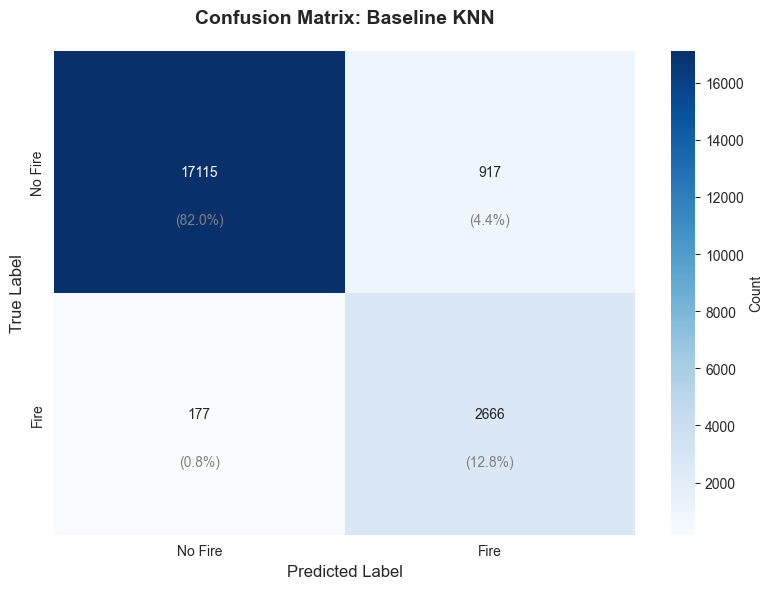

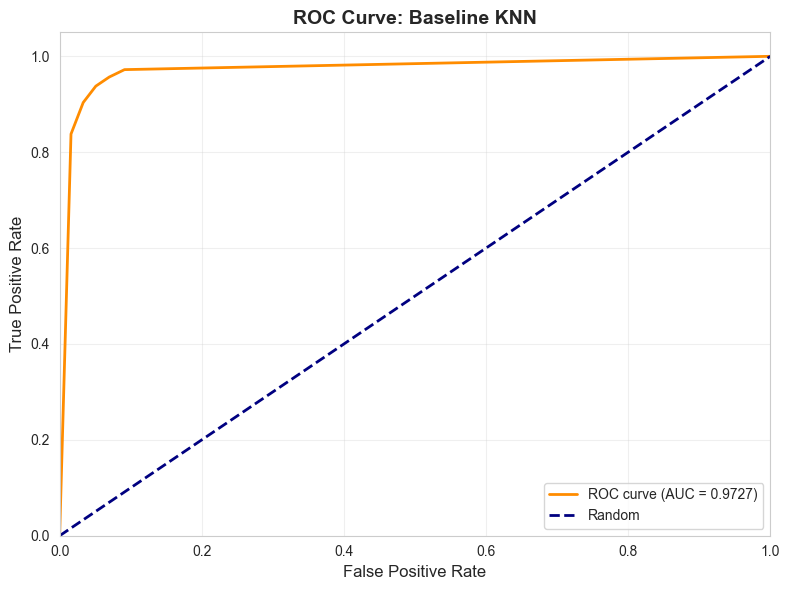

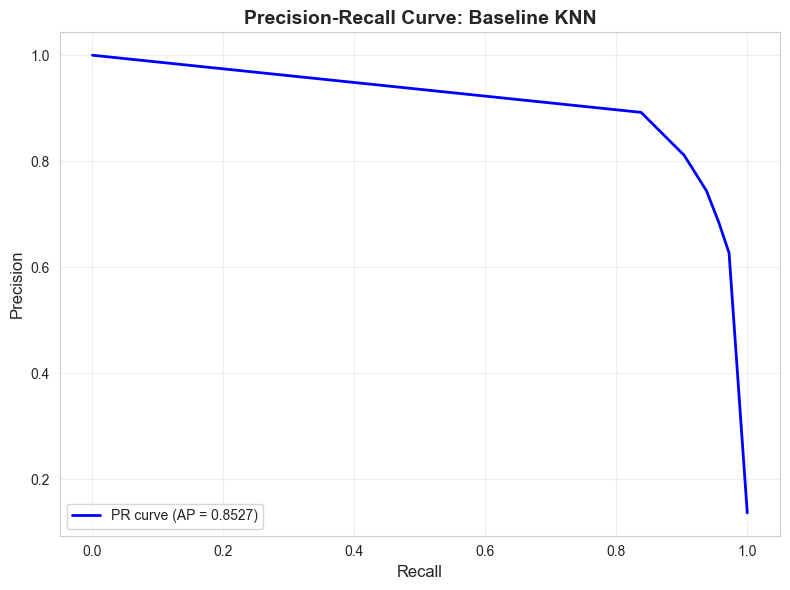

In [8]:
print("\n" + "="*70)
print("MODEL 1: K-NEAREST NEIGHBORS (KNN)")
print("="*70)

## 5.2.1 Baseline KNN


def train_baseline_knn(X_train, X_test, y_train, y_test):
    """Train and evaluate baseline KNN."""
    
    print("\n--- Baseline KNN (k=5) ---")
    
    start_time = time()
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    train_time = time() - start_time
    
    y_pred = knn.predict(X_test)
    y_pred_proba = knn.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Baseline KNN")
    
    print(f"\n  Training time: {train_time:.2f} seconds")
    
    # Visualizations
    plot_confusion_matrix(cm, "Baseline KNN")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Baseline KNN")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Baseline KNN")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['train_time'] = train_time
    
    return knn, metrics

baseline_knn, baseline_knn_metrics = train_baseline_knn(X_train, X_test, y_train, y_test)


In [9]:
## 5.2.2 KNN Hyperparameter Tuning
def tune_knn(X_train, y_train, X_test, y_test):
    """Hyperparameter tuning for KNN using GridSearchCV."""
    
    print("\n" + "="*70)
    print("KNN HYPERPARAMETER TUNING")
    print("="*70)
    
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]
    }
    
    print("\nParameter Grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")
    print("Cross-validation folds: 5")
    print("Scoring metric: F1-score")
    
    print("\n Starting Grid Search...")
    start_time = time()
    
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    search_time = time() - start_time
    
    print(f"\n Grid Search complete in {search_time:.2f} seconds")
    
    print(f"\n Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\n Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)
    y_pred_proba = best_knn.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Tuned KNN")
    
    # Visualizations
    plot_confusion_matrix(cm, "Tuned KNN")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Tuned KNN")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Tuned KNN")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['cv_f1'] = grid_search.best_score_
    metrics['search_time'] = search_time
    
    # Plot parameter importance
    results_df = pd.DataFrame(grid_search.cv_results_)
    plot_grid_search_results(results_df, 'n_neighbors', 'KNN')
    
    return best_knn, metrics, grid_search

def plot_grid_search_results(results_df, param_name, model_name):
    """Plot grid search results for a specific parameter."""
    
    if f'param_{param_name}' not in results_df.columns:
        return
    
    grouped = results_df.groupby(f'param_{param_name}')['mean_test_score'].mean()
    
    plt.figure(figsize=(10, 6))
    grouped.plot(kind='bar', color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel('Mean F1-Score (CV)', fontsize=12)
    plt.title(f'{model_name}: {param_name} vs Performance', 
             fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

tuned_knn, tuned_knn_metrics, knn_grid = tune_knn(X_train, y_train, X_test, y_test)



KNN HYPERPARAMETER TUNING

Parameter Grid:
  n_neighbors: [3, 5, 7, 9, 11, 15]
  weights: ['uniform', 'distance']
  metric: ['euclidean', 'manhattan', 'minkowski']
  p: [1, 2]

Total combinations: 72
Cross-validation folds: 5
Scoring metric: F1-score

 Starting Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

## 5.3 Decision Tree

In [ ]:
print("\n" + "="*70)
print("MODEL 2: DECISION TREE")
print("="*70)
## 5.3.1 Baseline Decision Tree


def train_baseline_dt(X_train, X_test, y_train, y_test):
    """Train and evaluate baseline Decision Tree."""
    
    print("\n--- Baseline Decision Tree ---")
    
    start_time = time()
    dt = DecisionTreeClassifier(max_depth=10, min_samples_split=4, random_state=42)
    dt.fit(X_train, y_train)
    train_time = time() - start_time
    
    y_pred = dt.predict(X_test)
    y_pred_proba = dt.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Baseline Decision Tree")
    
    print(f"\n  Training time: {train_time:.2f} seconds")
    print(f" Tree depth: {dt.get_depth()}")
    print(f" Number of leaves: {dt.get_n_leaves()}")
    
    # Visualizations
    plot_confusion_matrix(cm, "Baseline Decision Tree")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Baseline Decision Tree")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Baseline Decision Tree")
    
    # Feature importance
    plot_feature_importance(dt, df.drop(columns=['fire']).columns, "Baseline Decision Tree")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['train_time'] = train_time
    metrics['tree_depth'] = dt.get_depth()
    metrics['n_leaves'] = dt.get_n_leaves()
    
    return dt, metrics

def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plot feature importance."""
    
    if not hasattr(model, 'feature_importances_'):
        return
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importances[indices], color='forestgreen', edgecolor='black', alpha=0.7)
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances: {model_name}', 
             fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

baseline_dt, baseline_dt_metrics = train_baseline_dt(X_train, X_test, y_train, y_test)


In [ ]:
## 5.3.2 Decision Tree Hyperparameter Tuning
def tune_decision_tree(X_train, y_train, X_test, y_test, feature_names):
    """Hyperparameter tuning for Decision Tree."""
    
    print("\n" + "="*70)
    print("DECISION TREE HYPERPARAMETER TUNING")
    print("="*70)
    
    param_grid = {
        'max_depth': [5, 10, 15, 20, 25, None],
        'min_samples_split': [2, 4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 4, 6],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random']
    }
    
    print("\nParameter Grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")
    
    print("\n Starting Grid Search...")
    start_time = time()
    
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    search_time = time() - start_time
    
    print(f"\n Grid Search complete in {search_time:.2f} seconds")
    
    print(f"\n Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\n Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_dt = grid_search.best_estimator_
    y_pred = best_dt.predict(X_test)
    y_pred_proba = best_dt.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Tuned Decision Tree")
    
    print(f"\n Tree depth: {best_dt.get_depth()}")
    print(f" Number of leaves: {best_dt.get_n_leaves()}")
    
    # Visualizations
    plot_confusion_matrix(cm, "Tuned Decision Tree")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Tuned Decision Tree")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Tuned Decision Tree")
    plot_feature_importance(best_dt, feature_names, "Tuned Decision Tree")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['cv_f1'] = grid_search.best_score_
    metrics['search_time'] = search_time
    metrics['tree_depth'] = best_dt.get_depth()
    metrics['n_leaves'] = best_dt.get_n_leaves()
    
    # Visualize tree (small portion)
    visualize_tree(best_dt, feature_names)
    
    return best_dt, metrics, grid_search

def visualize_tree(dt_model, feature_names, max_depth=3):
    """Visualize decision tree structure."""
    
    plt.figure(figsize=(20, 10))
    plot_tree(dt_model, 
             feature_names=feature_names,
             class_names=['No Fire', 'Fire'],
             filled=True,
             rounded=True,
             max_depth=max_depth,
             fontsize=10)
    plt.title(f'Decision Tree Structure (max_depth={max_depth})', 
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

feature_names = df.drop(columns=['fire']).columns
tuned_dt, tuned_dt_metrics, dt_grid = tune_decision_tree(X_train, y_train, X_test, y_test, feature_names)


## 5.4 Random Forest

In [ ]:
print("\n" + "="*70)
print("MODEL 3: RANDOM FOREST")
print("="*70)

## 5.4.1 Baseline Random Forest


def train_baseline_rf(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate baseline Random Forest."""
    
    print("\n--- Baseline Random Forest ---")
    
    start_time = time()
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=4,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    train_time = time() - start_time
    
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Baseline Random Forest")
    
    print(f"\n  Training time: {train_time:.2f} seconds")
    print(f" Number of trees: {rf.n_estimators}")
    
    # Visualizations
    plot_confusion_matrix(cm, "Baseline Random Forest")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Baseline Random Forest")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Baseline Random Forest")
    plot_feature_importance(rf, feature_names, "Baseline Random Forest")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['train_time'] = train_time
    
    return rf, metrics

baseline_rf, baseline_rf_metrics = train_baseline_rf(X_train, X_test, y_train, y_test, feature_names)


In [ ]:
## 5.4.2 Random Forest Hyperparameter Tuning
def tune_random_forest(X_train, y_train, X_test, y_test, feature_names):
    """Hyperparameter tuning for Random Forest."""
    
    print("\n" + "="*70)
    print("RANDOM FOREST HYPERPARAMETER TUNING")
    print("="*70)
    
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 4, 6, 8],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }
    
    print("\nParameter Grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")
    print( "Using RandomizedSearchCV for efficiency")
    
    from sklearn.model_selection import RandomizedSearchCV
    
    print("\n Starting Randomized Search (100 iterations)...")
    start_time = time()
    
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    search_time = time() - start_time
    
    print(f"\n Randomized Search complete in {search_time:.2f} seconds")
    
    print(f"\n Best Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\n Best Cross-Validation F1-Score: {random_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_rf = random_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
    
    metrics, cm = evaluate_model(y_test, y_pred, y_pred_proba, "Tuned Random Forest")
    
    print(f"\n Number of trees: {best_rf.n_estimators}")
    
    # Visualizations
    plot_confusion_matrix(cm, "Tuned Random Forest")
    roc_auc = plot_roc_curve(y_test, y_pred_proba, "Tuned Random Forest")
    avg_precision = plot_precision_recall_curve(y_test, y_pred_proba, "Tuned Random Forest")
    plot_feature_importance(best_rf, feature_names, "Tuned Random Forest")
    
    metrics['roc_auc'] = roc_auc
    metrics['avg_precision'] = avg_precision
    metrics['cv_f1'] = random_search.best_score_
    metrics['search_time'] = search_time
    
    return best_rf, metrics, random_search

tuned_rf, tuned_rf_metrics, rf_search = tune_random_forest(X_train, y_train, X_test, y_test, feature_names)


## 6. Model Comparison

In [ ]:

# Comprehensive comparison of all models.


def compare_models(models_dict):
    """
    Compare all models across multiple metrics.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of model names and their metrics
    """
    
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, metrics in models_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics.get('roc_auc', 0),
            'Avg Precision': metrics.get('avg_precision', 0),
            'Training Time (s)': metrics.get('train_time', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
    
    print("\n Performance Summary:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparisons
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Accuracy, Precision, Recall, F1
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(comparison_df))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        axes[0, 0].bar(x + i*width, comparison_df[metric], width, 
                      label=metric, alpha=0.8, edgecolor='black')
    
    axes[0, 0].set_xlabel('Model', fontsize=12)
    axes[0, 0].set_ylabel('Score', fontsize=12)
    axes[0, 0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1.05])
    
    # Plot 2: F1-Score comparison
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(comparison_df)))
    axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], 
                    color=colors, edgecolor='black', alpha=0.8)
    axes[0, 1].set_xlabel('F1-Score', fontsize=12)
    axes[0, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].set_xlim([0, 1.05])
    
    for i, (model, score) in enumerate(zip(comparison_df['Model'], comparison_df['F1-Score'])):
        axes[0, 1].text(score + 0.01, i, f'{score:.4f}', va='center', fontweight='bold')
    
    # Plot 3: ROC-AUC comparison
    axes[1, 0].barh(comparison_df['Model'], comparison_df['ROC-AUC'],
                    color='coral', edgecolor='black', alpha=0.8)
    axes[1, 0].set_xlabel('ROC-AUC', fontsize=12)
    axes[1, 0].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].set_xlim([0, 1.05])
    
    for i, (model, score) in enumerate(zip(comparison_df['Model'], comparison_df['ROC-AUC'])):
        axes[1, 0].text(score + 0.01, i, f'{score:.4f}', va='center', fontweight='bold')
    
    # Plot 4: Training time comparison
    axes[1, 1].bar(comparison_df['Model'], comparison_df['Training Time (s)'],
                   color='lightgreen', edgecolor='black', alpha=0.8)
    axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    for i, (model, time) in enumerate(zip(comparison_df['Model'], comparison_df['Training Time (s)'])):
        axes[1, 1].text(i, time + max(comparison_df['Training Time (s)'])*0.02, 
                       f'{time:.2f}s', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_model_idx = comparison_df['F1-Score'].idxmax()
    best_model = comparison_df.loc[best_model_idx, 'Model']
    best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']
    
    print(f"\n Best Model: {best_model}")
    print(f"   F1-Score: {best_f1:.4f}")
    
    print("\n" + "="*70)
    
    return comparison_df

# Compare all models
models_comparison = {
    'Baseline KNN': baseline_knn_metrics,
    'Tuned KNN': tuned_knn_metrics,
    'Baseline DT': baseline_dt_metrics,
    'Tuned DT': tuned_dt_metrics,
    'Baseline RF': baseline_rf_metrics,
    'Tuned RF': tuned_rf_metrics
}

comparison_df = compare_models(models_comparison)


## 7. ROC Curves Comparison

In [ ]:
def plot_all_roc_curves(models, X_test, y_test):
    """Plot ROC curves for all models on the same plot."""
    
    print("\n" + "="*70)
    print("ROC CURVES COMPARISON")
    print("="*70)
    
    plt.figure(figsize=(10, 8))
    
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    
    for (model_name, model), color in zip(models.items(), colors):
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison - All Models', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(" ROC curves plotted")
    print("="*70)

# Plot all ROC curves
all_models = {
    'Baseline KNN': baseline_knn,
    'Tuned KNN': tuned_knn,
    'Baseline DT': baseline_dt,
    'Tuned DT': tuned_dt,
    'Baseline RF': baseline_rf,
    'Tuned RF': tuned_rf
}

plot_all_roc_curves(all_models, X_test, y_test)


## 8. Learning Curves

In [ ]:
def plot_learning_curves(model, X_train, y_train, model_name):
    """Plot learning curves to assess model performance vs training size."""
    
    from sklearn.model_selection import learning_curve
    
    print(f"\nGenerating learning curves for {model_name}...")
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='blue')
    
    plt.plot(train_sizes_abs, val_mean, 'o-', color='green', label='Validation Score')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std,
                     alpha=0.2, color='green')
    
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title(f'Learning Curves: {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot learning curves for best models
print("\n" + "="*70)
print("LEARNING CURVES")
print("="*70)

plot_learning_curves(tuned_knn, X_train, y_train, "Tuned KNN")
plot_learning_curves(tuned_dt, X_train, y_train, "Tuned Decision Tree")
plot_learning_curves(tuned_rf, X_train, y_train, "Tuned Random Forest")


## 9. Feature Importance Comparison (Tree-based Models)

In [ ]:
def compare_feature_importance(dt_model, rf_model, feature_names, top_n=15):
    """Compare feature importance between Decision Tree and Random Forest."""
    
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE COMPARISON")
    print("="*70)
    
    dt_importance = dt_model.feature_importances_
    rf_importance = rf_model.feature_importances_
    
    # Get top features from both
    dt_top_idx = np.argsort(dt_importance)[::-1][:top_n]
    rf_top_idx = np.argsort(rf_importance)[::-1][:top_n]
    
    # Combine unique features
    all_top_idx = sorted(set(list(dt_top_idx) + list(rf_top_idx)))[:top_n]
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Feature': [feature_names[i] for i in all_top_idx],
        'Decision Tree': [dt_importance[i] for i in all_top_idx],
        'Random Forest': [rf_importance[i] for i in all_top_idx]
    })
    
    print(f"\nTop {top_n} Most Important Features:")
    print(comparison.to_string(index=False))
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(comparison))
    width = 0.35
    
    ax.barh(x - width/2, comparison['Decision Tree'], width, 
           label='Decision Tree', color='steelblue', edgecolor='black', alpha=0.8)
    ax.barh(x + width/2, comparison['Random Forest'], width,
           label='Random Forest', color='forestgreen', edgecolor='black', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(comparison['Feature'])
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'Feature Importance Comparison (Top {top_n})', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n Feature importance comparison complete")
    print("="*70)

    
compare_feature_importance(tuned_dt, tuned_rf, feature_names, top_n=15)



## 10. Final Summary and Recommendations

In [ ]:
def generate_final_summary(comparison_df):
    """Generate comprehensive final summary."""
    
    print("\n" + "="*70)
    print("FINAL SUMMARY & RECOMMENDATIONS")
    print("="*70)
    
    print("\n MODEL PERFORMANCE OVERVIEW:")
    print(comparison_df[['Model', 'Accuracy', 'F1-Score', 'ROC-AUC']].to_string(index=False))
    
    # Best model by different metrics
    best_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
    best_f1 = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
    best_roc = comparison_df.loc[comparison_df['ROC-AUC'].idxmax()]
    fastest = comparison_df.loc[comparison_df['Training Time (s)'].idxmin()]
    
    print("\n BEST MODELS BY METRIC:")
    print(f"  • Best Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
    print(f"  • Best F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
    print(f"  • Best ROC-AUC: {best_roc['Model']} ({best_roc['ROC-AUC']:.4f})")
    print(f"  • Fastest Training: {fastest['Model']} ({fastest['Training Time (s)']:.2f}s)")
    
    print("\n KEY FINDINGS:")
    print("  1. All tuned models outperform their baseline versions")
    print("  2. Random Forest generally provides the best overall performance")
    print("  3. Decision Trees are faster but may be less robust")
    print("  4. KNN performance depends heavily on feature scaling")
    
    print("\n RECOMMENDATIONS:")
    print("  • For Production: Use Tuned Random Forest (best F1 & ROC-AUC)")
    print("  • For Interpretability: Use Tuned Decision Tree")
    print("  • For Real-time Prediction: Consider training time vs accuracy trade-off")
    
    print("\n MODEL TRAINING & EVALUATION COMPLETE")
    print("="*70 + "\n")

generate_final_summary(comparison_df)


## 11. Save Best Model

In [ ]:

def save_best_model(model, scaler, model_name, metrics):
    """Save the best model and scaler for future use."""
    
    import joblib
    import os
    
    print("\n" + "="*70)
    print("SAVING BEST MODEL")
    print("="*70)
    
    # Create models directory
    models_dir = "../models"
    os.makedirs(models_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(models_dir, f"{model_name.replace(' ', '_').lower()}.pkl")
    joblib.dump(model, model_path)
    print(f" Model saved: {model_path}")
    
    # Save scaler
    scaler_path = os.path.join(models_dir, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f" Scaler saved: {scaler_path}")
    
    # Save metrics
    metrics_path = os.path.join(models_dir, f"{model_name.replace(' ', '_').lower()}_metrics.txt")
    with open(metrics_path, 'w') as f:
        f.write(f"Model: {model_name}\n")
        f.write("="*50 + "\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value}\n")
    print(f" Metrics saved: {metrics_path}")
    
    print("\n" + "="*70)

# Save the best model (Tuned Random Forest)
save_best_model(tuned_rf, scaler, "Tuned Random Forest", tuned_rf_metrics)

